In [1]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import numpy.random as rand
import numpy.linalg as la
import gzip
import cPickle as pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import collections as mc

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

Loading Mechanical Network Deformation Solver Module


In [2]:
def calc_ext(net, disp):
    edgei = np.copy(net.edgei)
    edgej = np.copy(net.edgej)
    node_pos = np.copy(net.node_pos)
    DIM = net.DIM
    NE = net.NE
    NN = net.NN
    L = np.copy(net.L)
    
    ext = np.zeros(NE, float)
    for i in range(NE):
        
        posi = node_pos[DIM*edgei[i]:DIM*edgei[i]+DIM]
        posj = node_pos[DIM*edgej[i]:DIM*edgej[i]+DIM]

        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        
        bhat = bvec / la.norm(bvec)
        
        dispi = disp[DIM*edgei[i]:DIM*edgei[i]+DIM]
        dispj = disp[DIM*edgej[i]:DIM*edgej[i]+DIM]
        
        ext[i] = bhat.dot(dispj - dispi)
        
    return ext

In [26]:
DIM = 2

NN = 256
Lp = -1.0
irec = 3
eta = -1.0

NDISC = 1.0

rand.seed(irec)

nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


NF = 1


edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]
istrain_bonds = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_bonds = [[] for t in range(NF)]

edge_set = set()



##################################################

L = np.copy(net.L)

pos = np.array([0.35*L[0], 0.35*L[1]])
s = network.closestEdge(net, pos)[0]


inodesi[0].append(edgei[s])
inodesj[0].append(edgej[s])
istrain_bonds[0].append(s)

NTS = 1

pos = np.array([0.65*L[0], 0.65*L[1]])
t1 = network.closestEdge(net, pos)[0]
onodesi[0].append(edgei[t1])
onodesj[0].append(edgej[t1])
ostrain_bonds[0].append(t1)


######################################################

isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 


        ostrain[t].append(eta)

pert = []
meas = []

for t in range(NF):
    pert.append(talgs.Perturb())
#     pert[t].setInputStress(len(istrain_bonds[t]), istrain_bonds[t], istrain[t])
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
#     meas[t].setOutputStress(len(ostrain_bonds[t]), ostrain_bonds[t])
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])


obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain),
                                       relative=False, change=False)    


K_max = np.ones(net.NE, float) / net.eq_length

K_disc = np.ones(net.NE, float)


tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)

data = tuner.tune()

print data

data['network_label'] = nw_label
data['istrain_nodesi'] = inodesi
data['istrain_nodesj'] = inodesj
data['istrain'] = istrain
data['istrain_edges'] = istrain_bonds

data['ostrain_nodesi'] = onodesi
data['ostrain_nodesj'] = onodesj
data['delta_ostrain_target'] = ostrain
data['ostrain_edges'] = ostrain_bonds
tuner.solver.setIntStrengths(data['K'])
(disp, strain) = tuner.solver.solveDOF()
data['disp'] = disp[0]

Initial objective function: 0.49594633179
Removing 0 / 704.0 / 704 bonds would create zero modes...
{'disc': 0.0, 'bond': 468}
0 Objective function: 0.486675600889 Change: -0.00927073090146 Percent: -1.86930123427 %
Removing 0 / 703.0 / 704 bonds would create zero modes...
{'disc': 0.0, 'bond': 253}
1 Objective function: 0.479184499368 Change: -0.00749110152013 Percent: -1.5392391783 %
Removing 0 / 702.0 / 704 bonds would create zero modes...
{'disc': 0.0, 'bond': 477}
2 Objective function: 0.46959448325 Change: -0.00959001611864 Percent: -2.00132018696 %
Removing 0 / 701.0 / 704 bonds would create zero modes...
{'disc': 0.0, 'bond': 458}
3 Objective function: 0.458288005803 Change: -0.0113064774465 Percent: -2.40771087604 %
Removing 0 / 700.0 / 704 bonds would create zero modes...
{'disc': 0.0, 'bond': 288}
4 Objective function: 0.443703951991 Change: -0.0145840538127 Percent: -3.18229009444 %
Removing 0 / 699.0 / 704 bonds would create zero modes...
{'disc': 0.0, 'bond': 270}
5 Objec

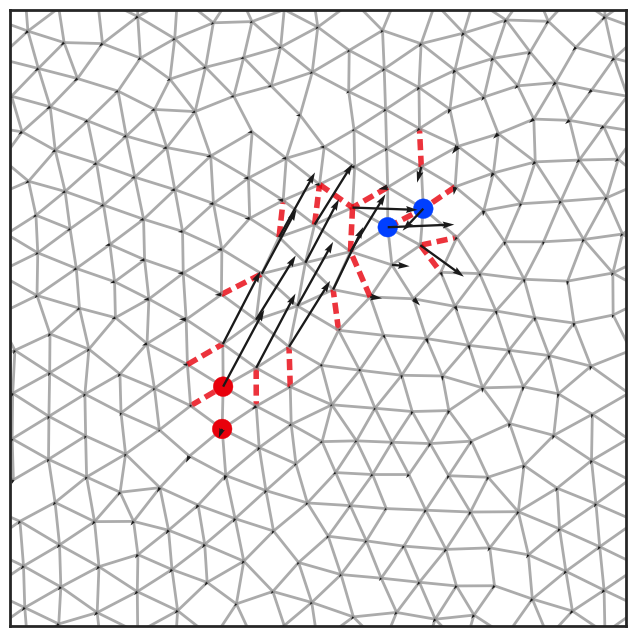

In [27]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='bright')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 

    

styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))
    styles[edge]['lw'] = 4.0
    styles[edge]['color'] = 'r'
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)
nplot.show_vecs(ax1, net, disp)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

plt.show()

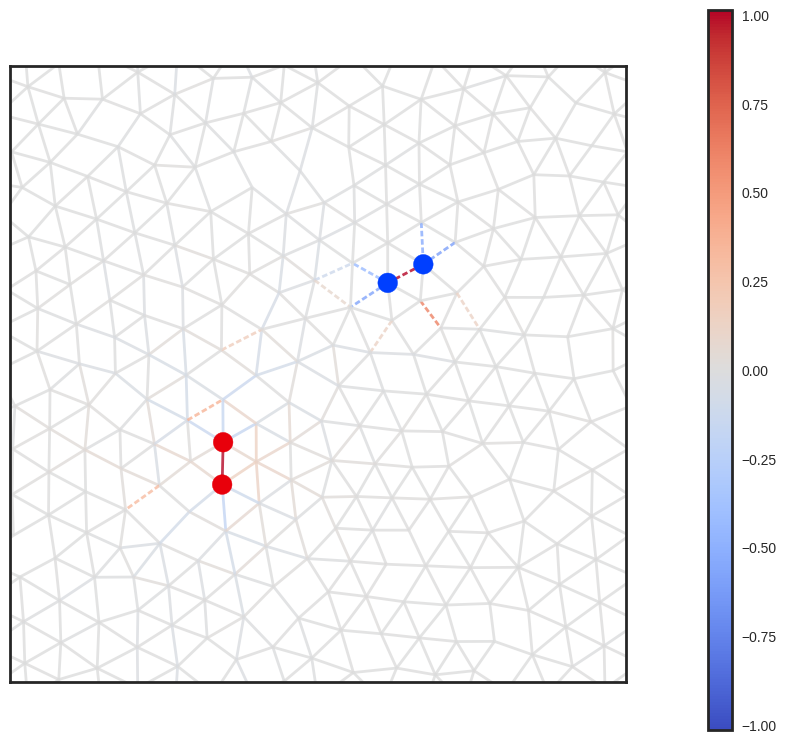

In [14]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='bright')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

ext = calc_ext(net, disp)
        
limit = np.max([np.abs(np.min(ext)), np.abs(np.max(ext))])
norm = mcolors.Normalize(vmin=-limit, vmax=limit)
# norm = mcolors.Normalize(vmin=np.min(ext), vmax=np.max(ext))
cmap = mpl.cm.coolwarm
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for edge in range(net.NE):
    styles[edge]['color'] = smap.to_rgba(ext[edge])    
    
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)
# nplot.show_vecs(ax1, net, disp)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

cax = fig.add_axes([1.0, 0.05, 0.03, 0.90])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

plt.show()

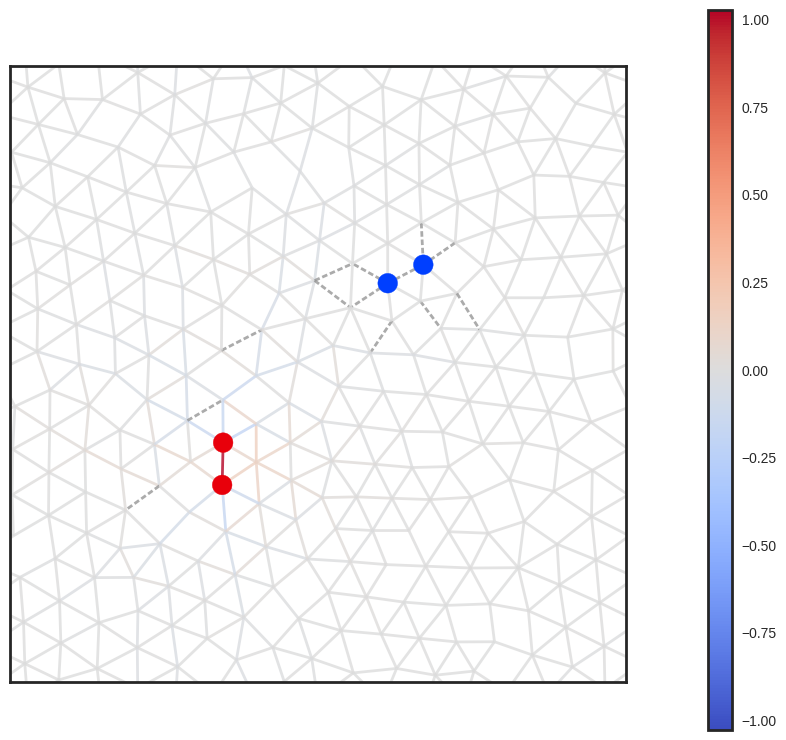

In [15]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='bright')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

tension = calc_ext(net, disp) * data['K']
# tension = np.where(tension == 0.0, 1.0, tension)
    
limit = np.max([np.abs(np.min(tension)), np.abs(np.max(tension))])
norm = mcolors.Normalize(vmin=-limit, vmax=limit)
# norm = mcolors.Normalize(vmin=np.min(tension), vmax=np.max(tension))
cmap = mpl.cm.coolwarm
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for edge in range(net.NE):
    styles[edge]['color'] = smap.to_rgba(tension[edge])    
    
for edge in removed:
    del styles[edge]['color']
    
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)
# nplot.show_vecs(ax1, net, disp)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

cax = fig.add_axes([1.0, 0.05, 0.03, 0.90])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

plt.show()

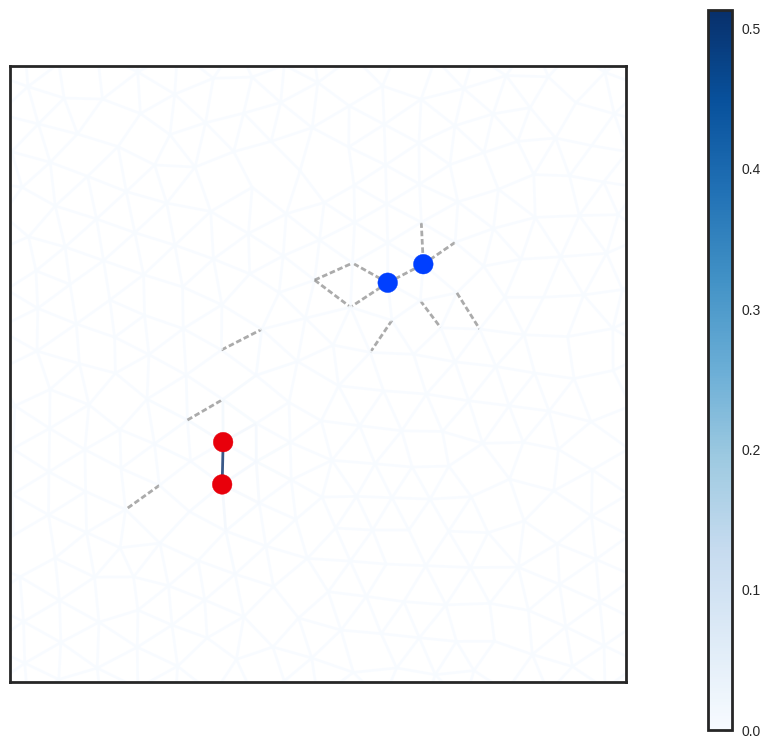

In [16]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='bright')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

energy = 0.5 * calc_ext(net, disp)**2 * data['K']
# energy = np.where(energy == 0.0, 1.0, energy)
    
limit = np.max(energy)
# norm = mcolors.Normalize(vmin=-limit, vmax=limit)
norm = mcolors.Normalize(vmin=np.min(energy), vmax=np.max(energy))
cmap = mpl.cm.Blues
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for edge in range(net.NE):
    styles[edge]['color'] = smap.to_rgba(energy[edge])    
    
for edge in removed:
    del styles[edge]['color']
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)
# nplot.show_vecs(ax1, net, disp)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

cax = fig.add_axes([1.0, 0.05, 0.03, 0.90])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

plt.show()